In [1]:
%%time
%%capture
!pip install tensorflow 
!pip install keras 
!pip install pillow 
!pip install numpy 
!pip install tqdm 
!pip install underthesea 
!pip install gensim 
!pip install fasttext 
!pip install nltk


CPU times: user 243 ms, sys: 94.1 ms, total: 337 ms
Wall time: 1min 59s


# 1. Import Thư viện


In [2]:
%%capture
%%time
import os
import sys
import string
import fasttext
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from pickle import dump, load
from underthesea import word_tokenize
from gensim.utils import simple_preprocess

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences

# from keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional, add
from keras.initializers import Constant
from keras.models import Model, load_model
from keras.utils.vis_utils import plot_model

from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from tqdm.notebook import tqdm
from nltk.translate.bleu_score import corpus_bleu


# 2. Xử lý dữ liệu

In [3]:
dataset_text = '../input/flickr8k-vi-caps'
dataset_images = '../input/flickr8k/Images'
sample_image = '1000268201_693b08cb0e.jpg'

text_file = dataset_text + '/' + 'captions_vi.txt'

In [4]:
#tạo từ điển các chú captions của ảnh
def load_doc(filename):
    file = open(filename, 'r', encoding='utf-8')
    text = file.read()
    file.close()
    
    return text

def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions = dict()
    for caption in captions[:-1]:
        img, cap = caption.split('\t')
        if img not in descriptions:
            descriptions[img] = [cap]
        else:
            descriptions[img].append(cap)
    return descriptions


descriptions = all_img_captions(text_file)
print('Length of descriptions:', len(descriptions))
print('Description before clean text')
descriptions[sample_image]

Length of descriptions: 8000
Description before clean text


['Một đứa trẻ mặc váy hồng đang trèo lên một bộ cầu thang theo lối vào.',
 'Một cô gái đi vào một tòa nhà bằng gỗ.',
 'Một cô bé trèo vào nhà chơi bằng gỗ.',
 'Một cô bé leo lên cầu thang đến nhà chơi của mình.',
 'Một cô bé mặc váy hồng đi vào cabin gỗ.']

In [5]:
#làm sạch các text
def cleaning_text(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for img, captions in descriptions.items():
        for idx, cap in enumerate(captions):
            desc = cap.replace(' - ', ' ').translate(table)
            desc = ' '.join(simple_preprocess(desc))
            desc = word_tokenize(desc, format='text')
            
            descriptions[img][idx] = desc
    return descriptions

clean_descriptions = cleaning_text(descriptions)
print('Descriptions after clean text')
clean_descriptions[sample_image]

Descriptions after clean text


['một đứa trẻ mặc váy hồng đang trèo lên một bộ cầu_thang theo lối vào',
 'một cô gái đi vào một tòa nhà bằng gỗ',
 'một cô bé trèo vào nhà chơi bằng gỗ',
 'một cô bé leo lên cầu_thang đến nhà chơi của mình',
 'một cô bé mặc váy hồng đi vào cabin gỗ']

In [6]:
def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(desc.split()) for desc in descriptions[key]]
    
    return vocab

vocab = text_vocabulary(clean_descriptions)
print('Length of vocabuary:', len(vocab))

Length of vocabuary: 6851


In [7]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, captions in descriptions.items():
        for cap in captions:
            lines.append(key + '\t' + cap)
    data = '\n'.join(lines)
    file = open(filename, 'w', encoding='utf-8')
    file.write(data)
    file.close()

save_descriptions(clean_descriptions, 'descriptions.txt')

# 3. Trích xuất vecto đặc trưng từ ảnh

In [8]:
def extract_feature(directory):
    model = InceptionV3(weights='imagenet')
    model = Model(model.input, model.layers[-2].output)
    
    features = dict()
    for img in tqdm(os.listdir(directory), file=sys.stdout):
        filename = directory + '/' + img
        image = load_img(filename, target_size=(299, 299))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        
        feature = model.predict(image, verbose=0)
        features[img] = feature
    return features

In [9]:
features = extract_feature(dataset_images)
dump(features, open('features_inception_v3.pkl', 'wb'))

96124928/96112376 [==============================] - 1s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]

In [10]:
# feature_path = '../input/flickr8k-feature-vector/features_inception_v3.pkl'
# features = load(open(feature_path, 'rb'))


In [11]:
features[sample_image]

array([[0.12277571, 0.3329491 , 0.75271606, ..., 0.2193965 , 0.302164  ,
        0.40283167]], dtype=float32)

# 4. Load dataset và train model

In [12]:
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split('\n')
    return photos

In [13]:
def load_descriptions(filename, photos):
    file = load_doc(filename)
    descriptions = dict()
    for line in file.split('\n'):
        line = line.split('\t')
        
        if len(line) < 1:
            continue
            
        image, cap = line[0], line[1]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = list()
            desc = 'startseq ' + cap + ' endseq'
            descriptions[image].append(desc)
    return descriptions

In [14]:
# def load_features(photos):
#     all_features = load(open(feature_path, 'rb'))
#     features = {img: all_features[img] for img in photos}
#     return features

def load_features(photos, features= features):
    return {img: features[img] for img in photos}

In [15]:
train_imgs = load_photos(dataset_text + '/' + 'trainImages.txt')
train_descriptions = load_descriptions('descriptions.txt', train_imgs)
train_features = load_features(train_imgs)

test_imgs = load_photos(dataset_text + '/' + 'testImages.txt')
test_descriptions = load_descriptions('descriptions.txt', test_imgs)
test_features = load_features(test_imgs)

# 5. Tokenizing từ 

In [16]:
def dict_to_list(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(desc) for desc in descriptions[key]]
    return all_desc

In [17]:
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    oov_token = 'unk'
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [18]:
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print('vocabulary:', vocab_size)

vocabulary: 3299


In [19]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(desc.split()) for desc in desc_list)
max_length = max_length(descriptions)
print('Max length of train set:', max_length)

Max length of train set: 41


In [20]:
def create_embedding_matrix(vocab):
    embedding_index = fasttext.load_model('../input/fasttext-vietnamese-word-vectors-full/cc.vi.300.bin')
    
    embedding_dim = 300
    hits = 0
    misses = 0
    vocab_size = len(vocab) + 1
    
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in vocab.items():
        embedding_vector = embedding_index[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    
    return embedding_matrix

vocab = tokenizer.word_index
embedding_matrix = create_embedding_matrix(vocab)
print(embedding_matrix.shape)

Converted 3298 words (0 misses)
(3299, 300)


# 6. Create data generator

In [21]:
def data_generator(descriptions, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    
    while True:
        for key, captions in descriptions.items():
            n += 1
            feature = features[key][0]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0
                
[a, b], c = next(data_generator(train_descriptions, features, tokenizer, max_length, vocab_size, 32))
a.shape, b.shape, c.shape

((2356, 2048), (2356, 41), (2356, 3299))

# 7. build CNN-RNN model

In [22]:
def define_model(vocab_size, max_length):
    embedding_dim = 300
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(
        vocab_size,
        embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        mask_zero=True,
        trainable=False,
    )(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = Bidirectional(LSTM(128))(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001))

    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

# import tensorflow as tf
# def define_model(vocab_size, max_length):
#     embedding_dim = 300
    
#     model = tf.keras.models.Sequential([
#         tf.keras.layers.Input(shape=(2048,)),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(256, activation='relu'),
        
#         tf.keras.layers.Input(shape=(max_length,)),
#         tf.keras.layers.Embedding(
#             vocab_size,
#             embedding_dim,
#             embeddings_initializer=Constant(embedding_matrix),
#             mask_zero=True,
#             trainable=False,
#         ),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
        
#         tf.keras.layers.Add(),
#         tf.keras.layers.Dense(256, activation='relu'),
#         tf.keras.layers.Dense(vocab_size, activation='softmax')
#     ])
    
#     model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
    
#     print(model.summary())
#     tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

#     return model

# 8. Train model

In [23]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train =', len(train_descriptions))
print('Photos: train =', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)


Dataset:  6000
Descriptions: train = 6000
Photos: train = 6000
Vocabulary Size: 3299
Description Length:  41


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 41, 300)      989700      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

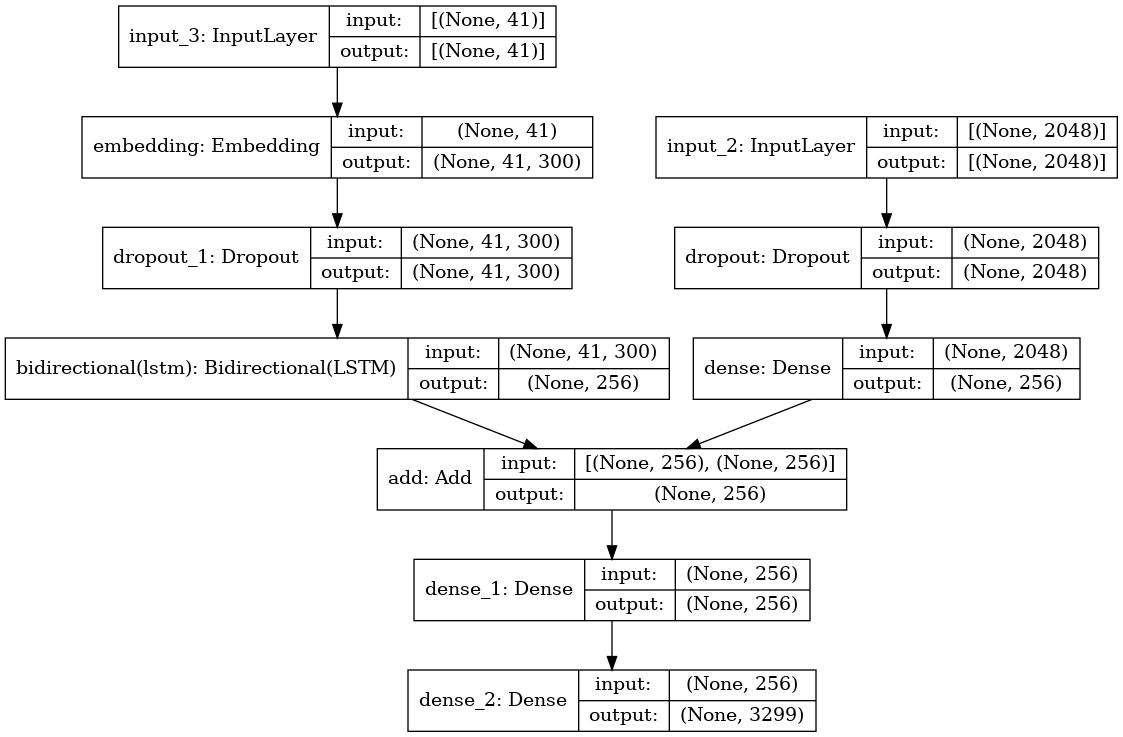

In [24]:
from IPython.display import Image

model = define_model(vocab_size, max_length)
Image(filename='model.png')

In [25]:
epochs = 50
batch_size = 32
steps = len(train_imgs) // batch_size

history = model.fit(data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size, batch_size), 
                    epochs=epochs, 
                    steps_per_epoch=steps, 
                    verbose=1)


Epoch 1/50
187/187 [==============================] - 51s 231ms/step - loss: 5.8393
Epoch 2/50
187/187 [==============================] - 44s 233ms/step - loss: 5.1026
Epoch 3/50
187/187 [==============================] - 43s 230ms/step - loss: 4.8476
Epoch 4/50
187/187 [==============================] - 43s 230ms/step - loss: 4.6240
Epoch 5/50
187/187 [==============================] - 43s 230ms/step - loss: 4.4101
Epoch 6/50
187/187 [==============================] - 42s 227ms/step - loss: 4.2466
Epoch 7/50
187/187 [==============================] - 43s 229ms/step - loss: 4.1199
Epoch 8/50
187/187 [==============================] - 43s 230ms/step - loss: 4.0145
Epoch 9/50
187/187 [==============================] - 43s 231ms/step - loss: 3.9258
Epoch 10/50
187/187 [==============================] - 43s 231ms/step - loss: 3.8485
Epoch 11/50
187/187 [==============================] - 43s 231ms/step - loss: 3.7792
Epoch 12/50
187/187 [==============================] - 43s 230ms/step - lo

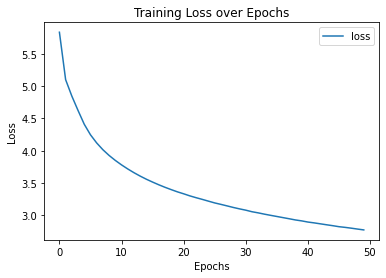

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [27]:
model.save("captions_vietnamese_flickr8k.h5")

# 9. tạo captions từ image

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = model.predict([image, seq], verbose=0)
        pred_ids = np.argmax(yhat)
        word = idx_to_word(pred_ids, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [30]:
# model = load_model('./captions_vietnamese_flickr8k.h5')
# actual, predicted = list(), list()

# for image in tqdm(test_imgs):
#     captions = test_descriptions[image]
#     actual_captions = [caption.split() for caption in captions]

#     y_pred = predict_caption(model, test_features[image], tokenizer, max_length)
#     y_pred = y_pred.split()

#     actual.append(actual_captions)
#     predicted.append(y_pred)

# # BLEU score
# print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

# 10. test model

In [31]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_path = os.path.join(dataset_images, image_name)
    image = Image.open(image_path)
    descriptions = load_descriptions('./descriptions.txt', train_imgs + test_imgs)
    captions = descriptions[image_name]
    print('-' * 20 + 'Actual' + '-' * 20)
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_name], tokenizer, max_length)
    print('-' * 20 + 'Predicted' + '-' * 20)
    y_pred_predict = ' '.join([word for word in y_pred.split() if word not in ['startseq', 'endseq']]) 
    print(y_pred_predict)
    plt.imshow(image)

--------------------Actual--------------------
startseq một cậu bé sải chân ra ngoài với bụng trên cỏ endseq
startseq một cậu bé mặc áo sơ_mi màu xanh nằm trên cỏ endseq
startseq cậu bé nằm sấp trên cỏ endseq
startseq cậu bé_nhỏ nằm sấp trên bãi cỏ endseq
startseq cậu bé đang nằm sấp trên cỏ endseq
--------------------Predicted--------------------
một cậu bé mặc áo sơ mi màu xanh và quần jean màu xanh và áo sơ mi màu xanh và áo sơ mi màu xanh và áo sơ mi màu xanh và áo sơ mi màu xanh và áo sơ


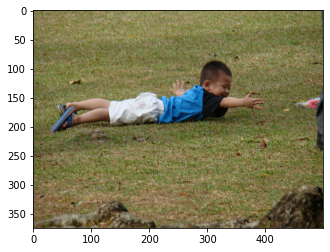

In [32]:
from random import sample

image_name = sample(train_imgs, 1)[0]
generate_caption(image_name)

In [33]:
!zip -r output.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/__notebook__.ipynb (deflated 89%)
  adding: kaggle/working/model.png (deflated 15%)
  adding: kaggle/working/tokenizer.pkl (deflated 50%)
  adding: kaggle/working/descriptions.txt (deflated 80%)
  adding: kaggle/working/captions_vietnamese_flickr8k.h5 (deflated 29%)
  adding: kaggle/working/features_inception_v3.pkl (deflated 10%)
